Sistem çalışıyor... Çıkmak için Q
Model yükleniyor, ilk açılış biraz sürebilir...


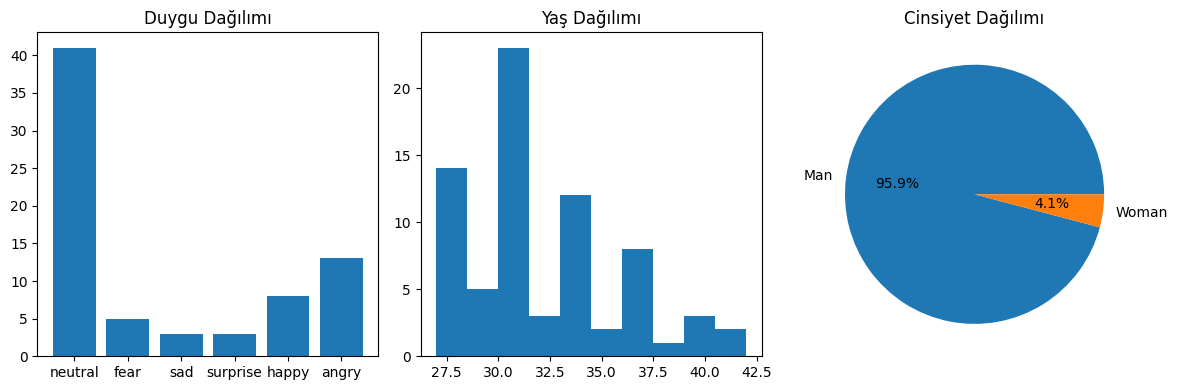

In [4]:
import cv2
import time
import threading
import csv
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque, Counter

# =====================================================
# GLOBAL DEĞİŞKENLER
# =====================================================

analysis_running = False 
faces_data = []  

# YENİ EKLENEN: Son geçerli yüzün görüldüğü zamanı tutar
last_valid_face_time = 0 
# YENİ EKLENEN: Yüz kaybolsa bile kutunun ekranda kalacağı süre (saniye)
PERSISTENCE_TIMEOUT = 2.0 

emotion_history = deque(maxlen=5) 
age_history = deque(maxlen=5) 

all_emotions = [] 
all_ages = [] 
all_genders = [] 

ANALYSIS_INTERVAL = 0.5 
last_analysis_time = 0 


# =====================================================
# YARDIMCI FONKSİYONLAR
# =====================================================

def age_to_range(age):
    try:
        age = int(age)
    except:
        return "Unknown"

    if age < 18: return "0-18"
    elif age < 25: return "18-25"
    elif age < 35: return "25-35"
    elif age < 50: return "35-50"
    else: return "50+"


# ÇOKLU YÜZ ANALİZİ
def analyze_faces(frame):
    faces = [] 
    try:
        results = DeepFace.analyze(
            frame,
            actions=['emotion', 'gender', 'age'],
            # ÖNEMLİ: Mimiklerde kopmaması için backend 'ssd' yapıldı.
            detector_backend='ssd', 
            enforce_detection=False,
            silent=True # Terminal kirliliğini önler
        )

        # DeepFace bazen liste bazen dict dönebilir, garantiye alalım
        if isinstance(results, dict):
            results = [results]

        for result in results:
            region = result.get('region', {})
            x, y, w, h = region.get('x',0), region.get('y',0), region.get('w',0), region.get('h',0)
            
            # Hatalı veya boş algılamaları ele
            if w == 0 or h == 0: continue

            faces.append({
                "emotion": result['dominant_emotion'],
                "gender": result['dominant_gender'],
                "age": result['age'],
                "box": (x, y, w, h)
            })

        return faces 

    except Exception as e:
        return [] 


# =====================================================
# ANALİZ THREAD (DÜZENLENDİ)
# =====================================================
def analysis_thread(frame):
    global faces_data, analysis_running, last_valid_face_time

    analysis_running = True 

    faces = analyze_faces(frame)
    
    # --- KRİTİK DEĞİŞİKLİK BURADA ---
    # Eğer yüz bulunduysa veriyi güncelle ve zaman sayacını sıfırla.
    # Eğer yüz bulunamadıysa (boş liste geldiyse), ESKİ VERİYİ SİLME!
    if faces:
        faces_data = faces
        last_valid_face_time = time.time() # Yüzü en son şu an gördüm diye not al
        
        # İstatistikleri sadece yüz bulunduğunda kaydet
        for face in faces:
            all_emotions.append(face["emotion"])
            all_ages.append(face["age"])
            all_genders.append(face["gender"])

            with open("analysis_log.csv", "a", newline="") as f: 
                writer = csv.writer(f)
                writer.writerow([
                    time.ctime(),
                    face["emotion"],
                    face["gender"],
                    face["age"]
                ])

    analysis_running = False


# =====================================================
# GRAFİK RAPORLARI
# =====================================================
def show_graphs():
    if not all_emotions:
        print("Grafik çizilecek veri yok.")
        return

    emotion_counts = Counter(all_emotions) 
    gender_counts = Counter(all_genders)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title("Duygu Dağılımı")

    plt.subplot(1, 3, 2)
    plt.hist(all_ages, bins=10) 
    plt.title("Yaş Dağılımı")

    plt.subplot(1, 3, 3)
    if gender_counts:
        plt.pie(gender_counts.values(), labels=gender_counts.keys(), autopct="%1.1f%%")
    plt.title("Cinsiyet Dağılımı")

    plt.tight_layout()
    plt.show()


# =====================================================
# ANA PROGRAM
# =====================================================
def main():
    global last_analysis_time, faces_data, last_valid_face_time

    cap = cv2.VideoCapture(0) 
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640) 
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) 

    prev_time = 0
    print("Sistem çalışıyor... Çıkmak için Q")
    print("Model yükleniyor, ilk açılış biraz sürebilir...")

    while True:
        ret, frame = cap.read() 
        if not ret: 
            break
        
        # Ayna görüntüsü (daha doğal kullanım için)
        frame = cv2.flip(frame, 1)

        current_time = time.time() 
        fps = 1 / (current_time - prev_time) if prev_time != 0 else 0 
        prev_time = current_time

        # -----------------------------
        # ZAMAN KONTROLLÜ ANALİZ
        # -----------------------------
        if (not analysis_running and current_time - last_analysis_time > ANALYSIS_INTERVAL):
            last_analysis_time = current_time 
            threading.Thread(
                target=analysis_thread, 
                args=(frame.copy(),), 
                daemon=True 
            ).start()

        # -----------------------------
        # ZAMAN AŞIMI KONTROLÜ (YENİ)
        # -----------------------------
        # Eğer son geçerli yüzü görmemizin üzerinden 2 saniye geçtiyse
        # artık kişinin gittiğine karar ver ve kutuyu sil.
        if time.time() - last_valid_face_time > PERSISTENCE_TIMEOUT:
            faces_data = []

        # -----------------------------
        # ÇİZİM (YEŞİL & KALIN)
        # -----------------------------
        for face in faces_data: 
            x, y, w, h = face["box"]
            age_range = age_to_range(face["age"])
            emotion = face['emotion']
            gender = face['gender']

            # 1. Yüz Çerçevesi (Yeşil, Kalınlığı 2)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # 2. Metin Hazırlığı
            text_info = f"{emotion} | {gender} | {age_range}"
            
            # 3. Yazıyı Yaz (Arka plan yok, sadece yazı)
            # (x, y - 10) -> Kutunun 10 piksel yukarısına yazar
            cv2.putText(
                frame, 
                text_info, 
                (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.65,           # Yazı boyutu
                (0, 255, 0),    # Renk: YEŞİL (B, G, R)
                2,              # Kalınlık: 2 (Bold olması için)
                cv2.LINE_AA     # Pürüzsüz kenarlar
            )

        cv2.putText(frame, f"FPS: {int(fps)}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        cv2.imshow("DeepFace - Kararli Analiz", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release() 
    cv2.destroyAllWindows() 
    show_graphs()


if __name__ == "__main__":
    main()